# Installing Scikit Learn

In [4]:
!pip3 install -U scikit-learn scipy matplotlib

Requirement already up-to-date: scipy in c:\users\nilsvn\appdata\local\programs\python\python36-32\lib\site-packages (1.4.1)
Requirement already up-to-date: matplotlib in c:\users\nilsvn\appdata\local\programs\python\python36-32\lib\site-packages (3.2.1)
Could not build wheels for scipy, since package 'wheel' is not installed.
Could not build wheels for matplotlib, since package 'wheel' is not installed.
Could not build wheels for numpy, since package 'wheel' is not installed.
Could not build wheels for cycler, since package 'wheel' is not installed.
Could not build wheels for kiwisolver, since package 'wheel' is not installed.
Could not build wheels for python-dateutil, since package 'wheel' is not installed.
Could not build wheels for pyparsing, since package 'wheel' is not installed.
Could not build wheels for six, since package 'wheel' is not installed.


You should consider upgrading via the 'c:\users\nilsvn\appdata\local\programs\python\python36-32\python.exe -m pip install --upgrade pip' command.


In [491]:
import pandas as pd
import numpy as np
from sklearn import svm
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import metrics
import time
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


In [422]:
def get_df(normal_path, attack_path_1, attack_path_2):
    df_normal = pd.read_csv(normal_path)
    df_attack_1 = pd.read_csv(attack_path_1)
    df_attack_2 = pd.read_csv(attack_path_2)
    
    df_normal['Class'] = 0 #create new 'Class' column containing only 0's.
    df_attack_1['Class'] = 1 #create new 'Class' column containing only 1's.
    df_attack_2['Class'] = 1 #create new 'Class' column containing only 1's.
    
    # feel free to change the amount depending on the amount of RAM you have (max 16,906).
    df_normal_1 = df_normal.head(5000)
    df_normal_2 = df_normal.tail(5000)
    
    df_train = pd.concat([df_attack_1, df_normal_1], ignore_index=True)
    df_test = pd.concat([df_attack_2, df_normal_2], ignore_index=True)
    return df_train, df_test

In [423]:
def get_X_y(df):
    X = df.drop('Class', axis=1)
    y = df['Class']
    return X, y

In [485]:
def SVM(X_train, X_test, y_train, y_test, threshold):
    model= svm.SVC(kernel='linear', probability=True)
    model.fit(X_train, y_train)
    y_pred = (model.predict_proba(X_test)[:,1] >= threshold).astype(bool)
    
    #print(metrics.confusion_matrix(y_test, y_pred))
    #print(metrics.classification_report(y_test, y_pred, digits=3))
    
    ACC = metrics.accuracy_score(y_test, y_pred)
    PRC = metrics.precision_score(y_test, y_pred) # when multiclass: average=None
    REC = metrics.recall_score(y_test, y_pred) # when multiclass: average=None
    return ACC, PRC, REC
    

In [486]:
def datetime_string_to_epoch(str):
    format = '%Y-%m-%d %H:%M:%S'
    if str[10] == 'T':
        format = '%Y-%m-%dT%H:%M:%S'
    t = time.strptime(str[:19], format)
    return time.mktime(t)

In [487]:
def preprocess_data(df):
    # filter to keep most relevant columns
    df = df[['TimeGenerated', 'ConditionalAccessStatus', 'Class']] # 'CorrelationId',
    # convert datetime strings to epoch
    df['TimeGenerated'] = df['TimeGenerated'].map(datetime_string_to_epoch)
    # split Pandas DataFrame into X (data) and y (corresponding class labels)
    X, y = get_X_y(df)
    # One-Hot Encoding for the nominal categorical variables
    X = pd.get_dummies(X[['TimeGenerated', 'ConditionalAccessStatus']]) # 'CorrelationId',
    # Standardization of values
    std = StandardScaler()
    X['TimeGenerated'] = std.fit_transform(X[['TimeGenerated']])
    # same for 'ResultType' ?
    
    return X, y

In [488]:
def thres_from_to_qty(fr, to, qty):
    qty -= 1
    res = [fr]
    diff = to - fr
    for i in range(1, qty + 1):
        res.append(fr + (i * diff) / qty)
    return res
        
    

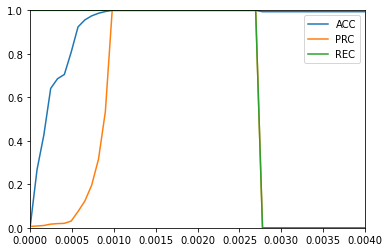

In [494]:
# change these file paths when reproducing results
# files are available on my github: https://github.com/NilsvN/my_thesis
NORMAL_PATH = "C:/Users/NilsvN/.jupyter/home/my_thesis/datasets/30days_anonymized_sigin_logs_column_corrected.csv"
ATTACK_PATH_1 = "C:/Users/NilsvN/.jupyter/home/my_thesis/datasets/brute_force_1.csv"
ATTACK_PATH_2 = "C:/Users/NilsvN/.jupyter/home/my_thesis/datasets/brute_force_2.csv"

# create df's from csv data
df_train, df_test = get_df(NORMAL_PATH, ATTACK_PATH_1, ATTACK_PATH_2)
X_train, y_train = preprocess_data(df_train)
X_test, y_test = preprocess_data(df_test)

# feel free to tweak as necessary
thres_from = 0
thres_to = 0.004
thres_qty = 50

# preparing data for plotting
thres_list = thres_from_to_qty(thres_from, thres_to, thres_qty)
acc_list = []
prc_list = []
rec_list = []

for thres in thres_list:
    acc, prc, rec = SVM(X_train, X_test, y_train, y_test, thres)
    acc_list.append(acc)
    prc_list.append(prc)
    rec_list.append(rec)

plt.plot(thres_list, acc_list)
plt.plot(thres_list, prc_list)
plt.plot(thres_list, rec_list)
plt.axis([thres_from, thres_to, 0, 1])
plt.legend(['ACC', 'PRC', 'REC'], loc='upper right')
plt.show()